In [3]:
import sys

sys.path.append("../..")
from cge_modeling import CGEModel, Variable, Parameter, Equation
from cge_modeling.base.cge import recursive_solve_symbolic, numba_linearize_cge_func
from cge_modeling.tools.numba_tools import numba_lambdify
from cge_modeling.pytensorf.compile import *
from tests.utilities.models import load_model_1, load_model_2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sympy as sp

from sympytensor import as_tensor
from sympytensor.pymc import SympyDeterministic
import pytensor.tensor as pt
import pytensor
import pymc as pm

import arviz as az

In [4]:
data = np.array(
    [
        [0, 0, 0, 1000, 2000, 4000],
        [0, 0, 0, 500, 2000, 500],
        [7000, 3000, 0, 0, 0, 0],
        [0, 0, 2000, 1000, 1000, 1000],
        [0, 0, 2500, 2000, 3500, 3000],
        [0, 0, 5500, 500, 2500, 1000],
    ]
)

cols = ["L_d", "K_d", "Men", "Ag", "Ind", "Serv"]
df = pd.DataFrame(data, columns=cols, index=cols, dtype="float64")
df

,L_d,K_d,Men,Ag,Ind,Serv
L_d,0.0,0.0,0.0,1000.0,2000.0,4000.0
K_d,0.0,0.0,0.0,500.0,2000.0,500.0
Men,7000.0,3000.0,0.0,0.0,0.0,0.0
Ag,0.0,0.0,2000.0,1000.0,1000.0,1000.0
Ind,0.0,0.0,2500.0,2000.0,3500.0,3000.0
Serv,0.0,0.0,5500.0,500.0,2500.0,1000.0


In [43]:
variable_info = [
    # Firm Variables
    Variable(name="Y", dims="i", description="Total output of good <dim:i>"),
    Variable(name="VA", dims="i", description="Labor-capital bundle produced by sector <dim:i>"),
    Variable(
        name="VC", dims="i", description="Intermediate goods bundle produced by sector <dim:i>"
    ),
    Variable(
        name="X", dims=("i", "j"), description="Demand for sector <dim:i> goods by sector <dim:j>"
    ),
    Variable(
        name="L_d", dims="i", extend_subscript=True, description="Labor demanded by sector <dim:i>"
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demanded by sector <dim:i>",
    ),
    # Household Variables
    Variable(name="U", description="Household utility"),
    Variable(name="C", dims="i", description="Household consumption of good <dim:i>"),
    Variable(name="income", latex_name="Omega", description="Total household income"),
    # Prices
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the labor-capital bundle in sector <dim:i>",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the intermediate bundle in sector <dim:i>",
    ),
    Variable(name="P", dims="i", description="Price level of final goods in sector <dim:i>"),
    # Other
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]

param_info = [
    # Firm Parameters
    Parameter(
        name="psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of labor-capital in sector <dim:i>'s final good",
    ),
    Parameter(
        name="psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of intermediate goods bundle in sector <dim:i>'s final product",
    ),
    Parameter(
        name="psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of sector <dim:i>'s final good in sector <dim:j>'s value chain bundle",
    ),
    Parameter(
        name="alpha",
        dims="i",
        description="Share of capital in sector <dim:i>'s production process",
    ),
    Parameter(
        name="phi_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    Parameter(name="A", dims="i", description="Total factor productivity in sector <dim:i>"),
    # Household Parameters
    Parameter(
        name="gamma",
        dims="i",
        description="Household utility weight on consumption of sector <dim:i> goods",
    ),
    # Exogenous variables
    Parameter(name="L_s", description="Exogenous household labor supply"),
    Parameter(name="K_s", description="Exogenous household capital stock"),
    Parameter(
        name="P_Ag_bar",
        latex_name=r"\bar{P}_{Ag}",
        description="Exogenous agricultural price level",
    ),
]

equations = [
    # # Firm Equations
    # Final Goods
    Equation("Final good production of sector <dim:i>", "P * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for labor-capital", "VA = psi_VA * Y"),
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        "VC * P_VC = Sum(P.subs({i:j}) * X.subs([(i,k), (j,i), (k,j)]), (j, 0, 2))",
    ),
    Equation(
        "Sector <dim:i> demand for sector <dim:j> intermediate input", "X = psi_X * VC.subs({i:j})"
    ),
    # Value add bundle
    Equation(
        "Sector <dim:i> production of labor-capital",
        "VA = A * (alpha * K_d ** ((phi_VA - 1) / phi_VA) +"
        "(1 - alpha) * L_d ** ((phi_VA - 1) / phi_VA)) ** (phi_VA / (phi_VA - 1))",
    ),
    Equation(
        "Sector <dim:i> demand for capital",
        "K_d = VA / A * (alpha * A * P_VA / r) ** phi_VA",
    ),
    Equation(
        "Sector <dim:i> demand for labor",
        "L_d = VA / A * ((1 - alpha) * A * P_VA / w) ** phi_VA",
    ),
    # # Household Equations
    Equation("Household income", "income = w * L_s + r * K_s"),
    Equation("Household utility", "U = Product(C**gamma, (i, 0, 2))"),
    Equation("Household demand for good <dim:i>", "C = gamma * income / P"),
    # # Market clearning conditions
    Equation("Labor market clearing", "L_s = Sum(L_d, (i, 0, 2)) + resid"),
    Equation("Capital market clearing", "K_s = Sum(K_d, (i, 0, 2))"),
    Equation("Sector <dim:i> goods market clearing", "Y = C + Sum(X, (j, 0, 2))"),
    Equation("Numeraire", 'P.subs({i:"Ag"}) = P_Ag_bar'),
]

In [44]:
sectors = ["Ag", "Ind", "Serv"]
n_sectors = len(sectors)
coords = {"i": sectors, "j": sectors}

mod = CGEModel(
    variables=variable_info,
    parameters=param_info,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=True,
)

In [45]:
mod.equation_table()

<IPython.core.display.Latex object>

In [46]:
data = {
    "L_d": df.loc["L_d", sectors].values,
    "K_d": df.loc["K_d", sectors].values,
    "X": df.loc[sectors, sectors].values,
    "Y": df.loc[sectors, :].values.sum(axis=1),
    "phi_VA": np.full(n_sectors, 3.0),
    "P": np.ones((n_sectors,)),
    "P_VA": np.ones((n_sectors,)),
    "P_VC": np.ones((n_sectors,)),
    "r": 1.0,
    "w": 1.0,
    "P_Ag_bar": 1.0,
}

In [65]:
def calibrate_model(L_d, K_d, Y, X, P, P_VA, P_VC, r, w, phi_VA, P_Ag_bar):
    calib_dict = {
        "L_d": L_d,
        "K_d": K_d,
        "Y": Y,
        "X": X,
        "P": P,
        "r": r,
        "w": w,
        "P_VA": P_VA,
        "P_VC": P_VC,
        "phi_VA": phi_VA,
        "P_Ag_bar": P_Ag_bar,
    }

    rho_VA = (phi_VA - 1) / phi_VA

    # Numeraire
    resid = 0.0

    # Household calibration
    L_s = L_d.sum()
    K_s = K_d.sum()
    income = w * L_s + r * K_s
    C = Y - X.sum(axis=1)
    gamma = C / income * P
    U = (C**gamma).prod()

    # Firm calibration
    VA = (w * L_d + r * K_d) / P_VA
    VC = (P[:, None] * X).sum(axis=0) / P_VC

    alpha = r * K_d ** (1 / phi_VA) / ((r * K_d ** (1 / phi_VA) + w * L_d ** (1 / phi_VA)))
    A = VA * (alpha * K_d**rho_VA + (1 - alpha) * L_d**rho_VA) ** (-1 / rho_VA)

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC[None]

    calib_dict["VA"] = VA
    calib_dict["VC"] = VC
    calib_dict["psi_VC"] = psi_VC
    calib_dict["psi_VA"] = psi_VA
    calib_dict["psi_X"] = psi_X
    calib_dict["alpha"] = alpha
    calib_dict["A"] = A

    calib_dict["income"] = income
    calib_dict["C"] = C
    calib_dict["U"] = U
    calib_dict["gamma"] = gamma

    calib_dict["K_s"] = K_s
    calib_dict["L_s"] = L_s
    calib_dict["resid"] = resid
    calib_dict["w"] = w

    return calib_dict

In [73]:
calibrated_data = calibrate_model(**data)

var_inputs = np.r_[*[np.atleast_1d(calibrated_data[x]).ravel() for x in mod.variable_names]]
param_inputs = np.r_[*[np.atleast_1d(calibrated_data[x]).ravel() for x in mod.parameter_names]]

long_data = {x: var_inputs[i] for i, x in enumerate(mod.unpacked_variable_names)}
long_data.update({x: param_inputs[i] for i, x in enumerate(mod.unpacked_parameter_names)})

In [78]:
initial_state = mod.calibrate(long_data)

In [80]:
res = mod.simulate(initial_state, final_delta_pct={"L_s": 1.5})

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


<Axes: >

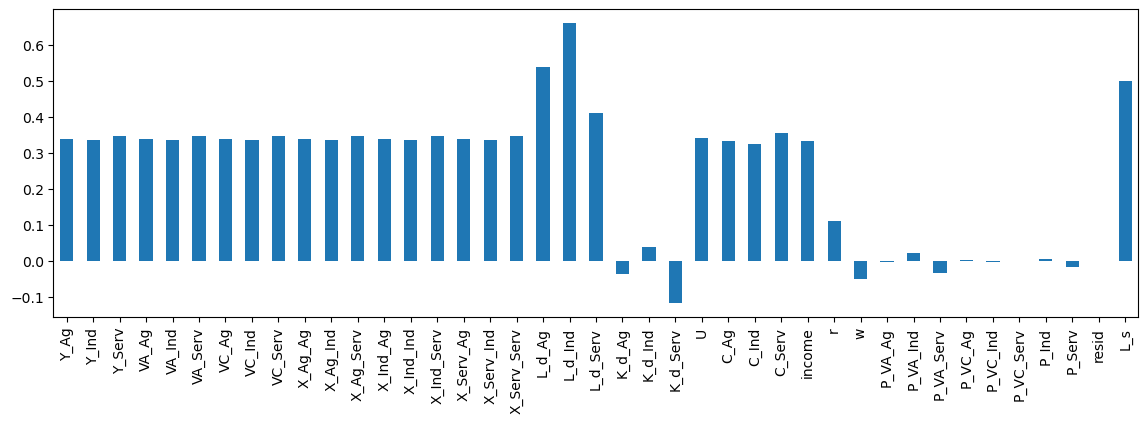

In [100]:
fig, ax = plt.subplots(figsize=(14, 4))
res.to_frame().pct_change(axis=1).loc[lambda x: np.abs(x.fitted) > 1e-5].fitted.plot.bar(ax=ax)

In [11]:
import functools as ft


def eval_func_maybe_exog(X, exog, f):
    if hasattr(exog, "data") and np.isnan(exog.data):
        out = f(*X)
    else:
        out = f(*X, *exog)

    return out


def _newton_step(X, exog, F, J_inv, step_size, tol):
    F_X = eval_func_maybe_exog(X, exog, F)
    J_inv_X = eval_func_maybe_exog(X, exog, J_inv)

    new_X = X - step_size * J_inv_X @ F_X
    F_new_X = eval_func_maybe_exog(new_X, exog, F)

    return (X, new_X, F_X, F_new_X)


def no_op(X, F, J_inv, step_size, tol):
    return (X, X, X, X)


def compute_norms(X, new_X, F_X, F_new_X):
    norm_X = pt.linalg.norm(X, ord=1)
    norm_new_X = pt.linalg.norm(new_X, ord=1)
    norm_root = pt.linalg.norm(F_X, ord=1)
    norm_root_new = pt.linalg.norm(F_new_X, ord=1)
    norm_step = pt.linalg.norm(new_X - X, ord=1)

    return norm_X, norm_new_X, norm_root, norm_root_new, norm_step


def _check_convergence(norm_step, norm_root, tol):
    #     new_converged = pt.or_(pt.lt(norm_step, tol), pt.lt(norm_root, tol))
    new_converged = pt.lt(norm_root, tol)
    return new_converged


def check_convergence(norm_step, norm_root, converged, tol):
    return pytensor.ifelse.ifelse(
        converged, np.array(True), _check_convergence(norm_step, norm_root, tol)
    )


def check_stepsize(norm_root, norm_root_new, step_size, initial_step_size):
    is_decreasing = pt.lt(norm_root_new, norm_root)

    return pytensor.ifelse.ifelse(
        is_decreasing, (is_decreasing, initial_step_size), (is_decreasing, step_size * 0.5)
    )


def backtrack_if_not_decreasing(is_decreasing, X, new_X):
    return pytensor.ifelse.ifelse(is_decreasing, new_X, X)


def scan_body(X, converged, step_size, n_steps, tol, exog, F, J_inv, initial_step_size):
    out = pytensor.ifelse.ifelse(
        converged,
        no_op(X, F, J_inv, step_size, tol),
        _newton_step(X, exog, F, J_inv, step_size, tol),
    )

    X, new_X, F_X, F_new_X = [out[i] for i in range(4)]
    norm_X, norm_new_X, norm_root, norm_root_new, norm_step = compute_norms(X, new_X, F_X, F_new_X)
    is_converged = check_convergence(norm_step, norm_root, converged, tol)

    is_decreasing, new_step_size = check_stepsize(
        norm_root, norm_root_new, step_size, initial_step_size
    )

    return_X = backtrack_if_not_decreasing(is_decreasing, X, new_X)
    new_n_steps = n_steps + (1 - is_converged)

    return return_X, is_converged, new_step_size, new_n_steps


def pytensor_root(f, f_jac_inv, x0, exog=None, step_size=1, max_iter=100, tol=1e-8):

    init_step_size = np.float64(step_size)
    root_func = ft.partial(scan_body, F=f, J_inv=f_jac_inv, initial_step_size=init_step_size)
    converged = np.array(False)
    n_steps = 0

    if exog is None:
        exog = pt.as_tensor_variable(np.nan)

    outputs, updates = pytensor.scan(
        root_func,
        outputs_info=[x0, converged, init_step_size, n_steps],
        non_sequences=[tol, exog],
        n_steps=max_iter,
        strict=True,
    )

    root, converged, step_size, n_steps = outputs

    return root, converged, step_size, n_steps

## Simpler Model

In [12]:
variables = Y, C, L_d, K_d, P, r, resid = list(
    map(pt.dscalar, ["Y", "C", "L_d", "K_d", "P", "r", "resid"])
)
params = K_s, L_s, A, alpha, w = list(map(pt.dscalar, ["K_s", "L_s", "A", "alpha", "w"]))


def f_model(*args):
    Y, C, L_d, K_d, P, r, resid, *params = args
    K_s, L_s, A, alpha, w = params

    equations = pt.stack(
        [
            Y - A * K_d**alpha * L_d ** (1 - alpha),
            r * K_d - alpha * Y * P,
            w * L_d - (1 - alpha) * Y * P,
            Y - C,
            P * C - w * L_s - r * K_s,
            K_d - K_s,
            L_d - L_s + resid,
        ]
    )

    return equations


equations = f_model(*variables, *params)
jac = pt.stack(pytensor.gradient.jacobian(equations, variables)).T
jac_inv = pt.linalg.solve(jac, pt.identity_like(jac), check_finite=False)

f_jac = pytensor.compile.builders.OpFromGraph(variables + params, outputs=[jac], inline=True)
f_jac_inv = pytensor.compile.builders.OpFromGraph(
    variables + params, outputs=[jac_inv], inline=True
)

[Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Sub.0, Add.0]

In [ ]:
obs_data = np.array([11000, 11000, 7000, np.nan, 1, 1, 0])
not_na = ~np.isnan(obs_data)
eye = np.eye(7)
Z = eye[not_na, :]
not_Z = eye[~not_na, :]

In [74]:
def predict_unobserved(Z, not_Z, mu, cov, y_obs):
    mu_o = Z @ mu
    mu_u = not_Z @ mu
    cov_oo = Z @ cov @ Z.T
    cov_uu = not_Z @ cov @ not_Z.T
    cov_uo = not_Z @ cov @ Z.T

    cov_oo_inv = pt.linalg.solve(cov_oo, pt.identity_like(cov_oo), assume_a="pos")

    beta = cov_uo @ cov_oo_inv
    resid = y_obs - mu_o

    mu_hat = mu_u + beta @ resid
    Sigma_hat = cov_uu - beta @ cov_oo @ beta.T

    return mu_hat, Sigma_hat

In [76]:
coords = {
    "equation": np.arange(7, dtype=int),
    "equation_aux": np.arange(7, dtype=int),
    "variable": ["Y", "C", "L_d", "K_d", "P", "r", "resid"],
    "obs_variable": ["Y", "C", "L_d", "P", "r", "resid"],
    "missing_variable": ["K_d"],
    "parameter": ["K_s", "L_s", "A", "alpha", "w"],
}

with pm.Model(coords=coords) as m:
    # Parameters
    pm_A = pm.Gamma("A", 2, 1)
    pm_alpha = pm.Beta("alpha", 3, 3)
    pm_K_s = pm.Normal("K_s", 4000, 100)
    pm_L_s = pm.Normal("L_s", 7000, 100)

    pm_P = pt.ones((), dtype="float64")
    pm_r = pt.ones((), dtype="float64")
    pm_w = pt.ones((), dtype="float64")
    pm_resid = pt.zeros((), dtype="float64")

    pm_params = pm.Deterministic(
        "params", pt.stack([pm_K_s, pm_L_s, pm_A, pm_alpha, pm_w]), dims=["parameter"]
    )

    Y0 = pm.Normal("Y", 11000, 1000)
    C0 = pm.Normal("C", 11000, 1000)
    Kd0 = pm.Normal("K_d", 4000, 100)
    Ld0 = pm.Normal("L_d", 7000, 100)

    #     x0 = pt.as_tensor(np.array([11000, 11000, 4000, 7000, 1, 1, 0], dtype='float64'))
    x0 = pm.Deterministic("x0", pt.stack([Y0, C0, Ld0, Kd0, pm_P, pm_r, 0.0]), dims=["variable"])

    root_history, converged, step_size, n_steps = pytensor_root(
        f_model, f_jac_inv, x0=x0, exog=pm_params
    )
    root = pm.Deterministic("root", root_history[-1], dims=["variable"])
    error = pm.Deterministic("error", f_model(*root, *pm_params), dims=["equation"])
    success = pm.Deterministic("success", pt.allclose(error, 0))

    sigma = pm.HalfNormal("sigma", [10, 10, 10, 10, 0.1, 0.1, 0.1], dims=["variable"])
    jac = f_jac(*root, *pm_params).T
    row_norm = (jac**2).sum(axis=1) ** 0.5
    normed_jac = jac / row_norm[:, None]

    rho = normed_jac @ normed_jac.T

    cov = pt.diag(sigma) @ rho @ pt.diag(sigma)
    cov = 0.5 * (cov + cov.T) + pt.identity_like(cov) * 1e-4
    chol = pt.linalg.cholesky(Z @ cov @ Z.T)

    y_hat = pm.MvNormal(
        "y_hat", mu=Z @ root, chol=chol, dims=["obs_variable"], observed=obs_data[not_na]
    )

    #     missing_mu, missing_cov = predict_unobserved(Z, not_Z, root, cov, obs_data[not_na])
    #     y_missing = pm.MvNormal('y_missing', mu=missing_mu, cov=missing_cov, dims=['missing_variable'])

    pm.Potential("optimizer_failure", pt.switch(success, 0, -np.inf))

    idata = pm.sample(nuts_sampler="numpyro", target_accept=0.95, tune=10, draws=10)
#     idata = pm.sample_smc(kernel=pm.smc.MH,
#                           draws=5_000,
#                           correlation_threshold=1e-2,
#                           threshold=0.5,
#                           chains=4,
#                           progressbar=False)

Only 10 samples in chain.


Compiling...
Compilation time =  0:00:05.924672
Sampling...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Sampling time =  0:00:09.130185
Transforming variables...
Transformation time =  0:00:01.223683


In [77]:
var_names = ["~root", "~params", "~x0", "~error", "~success"]

In [78]:
az.summary(idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
K_s,4000.182,0.584,3999.544,4001.148,0.184,0.134,11.0,20.0,3.25
L_s,6999.793,0.247,6999.528,7000.165,0.075,0.055,11.0,20.0,2.89
Y,11000.145,0.625,10999.156,11000.817,0.196,0.143,11.0,28.0,2.85
C,11000.071,0.868,10999.034,11001.132,0.274,0.200,11.0,20.0,3.36
K_d,3999.916,0.636,3999.438,4000.991,0.200,0.146,13.0,39.0,2.14
L_d,7000.178,0.565,6999.300,7000.894,0.178,0.130,11.0,64.0,2.84
A,2.075,0.312,1.541,2.585,0.096,0.070,11.0,20.0,3.53
alpha,0.474,0.085,0.359,0.596,0.026,0.019,11.0,20.0,2.78
sigma[Y],13.853,8.517,5.458,30.312,2.666,1.942,10.0,20.0,4.56
sigma[C],9.854,4.338,4.180,15.749,1.364,0.994,10.0,20.0,4.51


/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['y_hat'] have not been found and will be ignored
  warnings.warn(


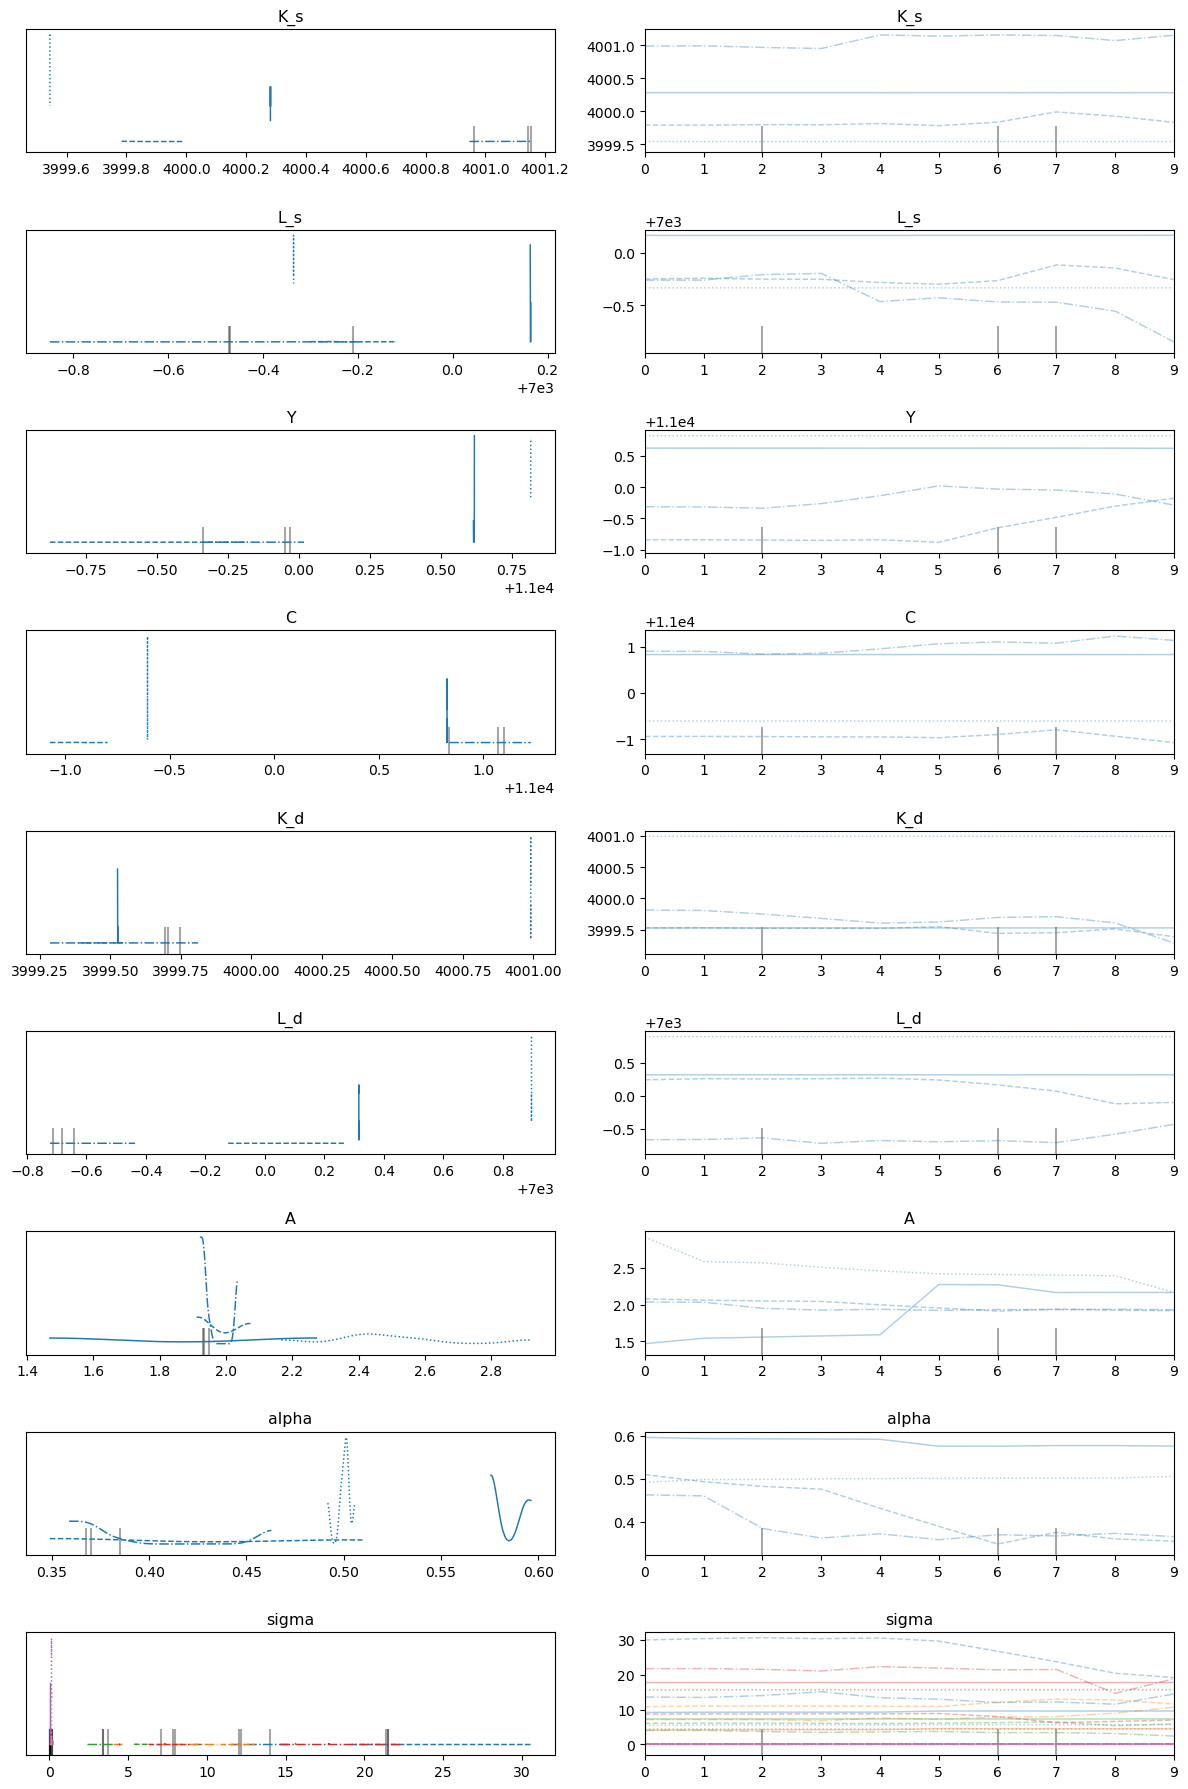

In [79]:
var_names = ["~root", "~params", "~x0", "~error", "~success", "~y_hat"]
az.plot_trace(idata, var_names=var_names)
plt.tight_layout()

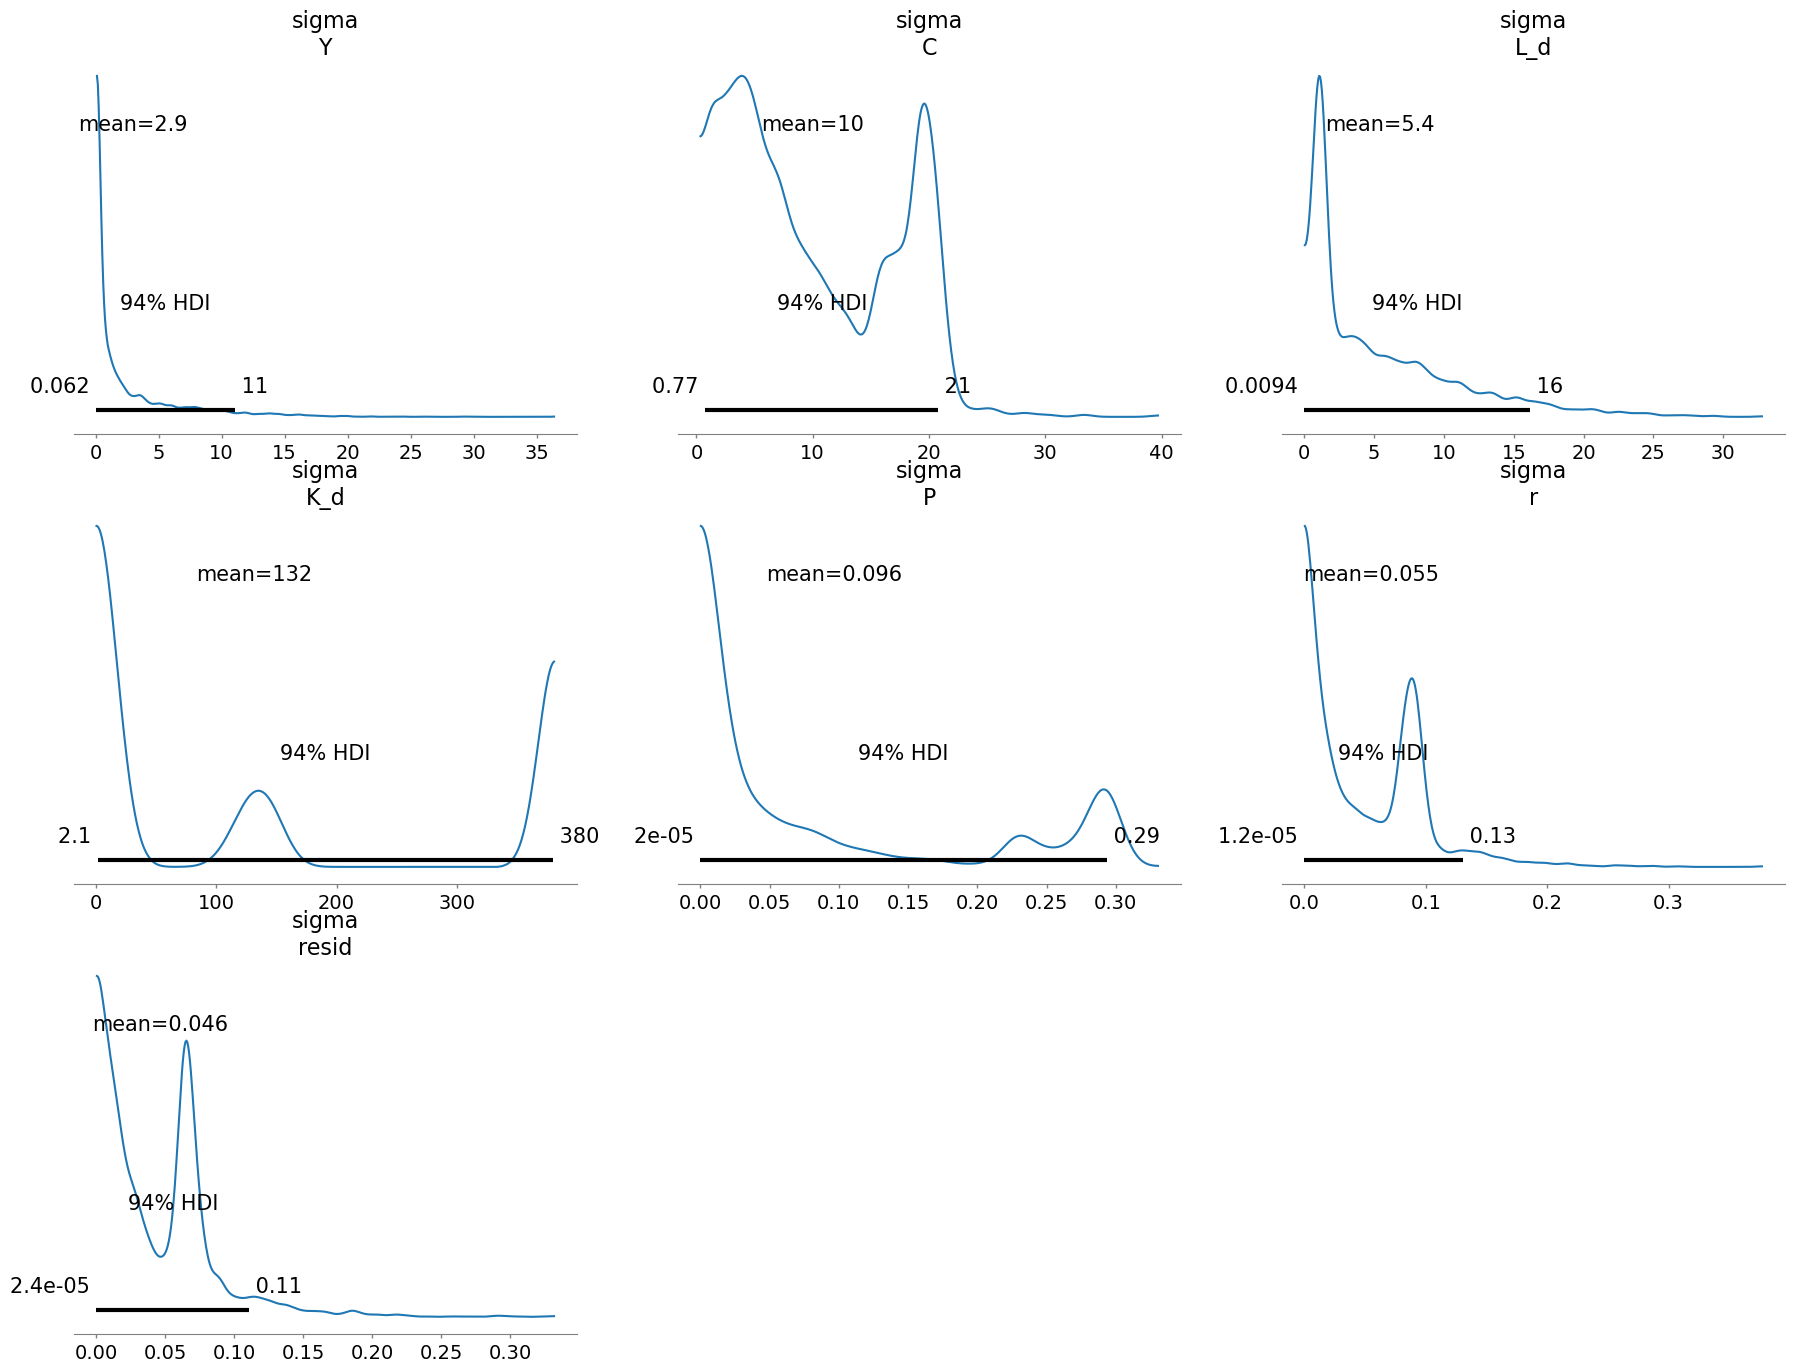

In [21]:
az.plot_posterior(idata, var_names=["sigma"]);

In [ ]:
with m:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [ ]:
az.plot_posterior(idata.posterior_predictive, var_names=["y_hat"]);

In [ ]:
az.plot_pair(idata, divergences=True, var_names=["root"]);

## Attack the full model

Step 1 is how to nicely vectorize things. I'd really rather work with vectorized expressions than with a big stack of equations. 

In [1054]:
mod.variable_names

['Y',
 'VA',
 'VC',
 'X',
 'L_d',
 'K_d',
 'U',
 'C',
 'income',
 'r',
 'w',
 'P_VA',
 'P_VC',
 'P',
 'resid']

In [1056]:
variables

[Y, VA, VC, X, L_d, K_d, U, C, income, r, w, P_VA, P_VC, P, resid]

In [1058]:
for eq in mod.equations:
    display(eq)

Final good production of sector <dim:i>

Sector <dim:i> demand for intermediate goods bundle

Sector <dim:i> demand for labor-capital

Sector <dim:i> production of intermediate goods bundle

Sector <dim:i> demand for sector <dim:j> intermediate input

Sector <dim:i> production of labor-capital

Sector <dim:i> demand for capital

Sector <dim:i> demand for labor

Household income

Household utility

Household demand for good <dim:i>

Labor market clearing

Capital market clearing

Sector <dim:i> goods market clearing

Numeraire

In [14]:
TENSOR_FACTORY = {0: pt.dscalar, 1: pt.dvector, 2: pt.dmatrix, 3: pt.dtensor3}


def make_pytensor_variables(variables):
    out = []
    for var in variables:
        ndim = len(var.dims)
        core_dims = max(0, ndim)
        out.append(TENSOR_FACTORY[core_dims](var.name))
    return out


def add_batch_to(x):
    ndim = x.type.ndim
    return TENSOR_FACTORY[ndim + 1](x.name)

Sub(Mul.0, Mul.0)


TypeError: TensorType does not support iteration.
	Did you pass a PyTensor variable to a function that expects a list?
	Maybe you are using builtins.sum instead of pytensor.tensor.sum?

In [86]:
X = pt.dmatrix("X")
Y = pt.dvector("Y")
phi = pt.dmatrix("phi")
a = pt.scalar("a")

i = 3
j = 3

n_eq = i + i * j
equations = [(X - phi * Y[:, None]).ravel(), Y - a]

system = pt.concatenate([x.ravel() for x in equations], axis=0)
jac = pytensor.gradient.jacobian(system, [X, Y])
jac2 = pt.concatenate([pt.atleast_2d(x).reshape((n_eq, -1)) for x in jac], axis=-1)
f = pytensor.function([X, Y, phi, a], system)
f_jac = pytensor.function([X, Y, phi, a], jac)
f_jac2 = pytensor.function([X, Y, phi, a], jac2)

In [87]:
f(np.eye(3), np.ones(3), np.eye(3), 0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])

In [88]:
jac_eval = f_jac(np.eye(3), np.ones(3), np.eye(3), 0)
jac_eval2 = f_jac2(np.eye(3), np.ones(3), np.eye(3), 0)

In [89]:
[x.shape for x in jac_eval]

[(12, 3, 3), (12, 3)]

In [90]:
jac_eval2.shape

(12, 12)

In [327]:
def f_model(variables, parameters):
    Y, VA, VC, X, L_d, K_d, U, C, Ω, r, w, P_VA, P_VC, P, resid = variables
    psi_VA, psi_VC, psi_X, alpha, phi_VA, A, gamma, L_s, K_s, P_Ag_bar = parameters

    equations = [
        P * Y - P_VA * VA - P_VC * VC,
        VC - Y * psi_VC,
        VA - Y * psi_VA,
        (P_VC[None] * VC[None] - (P[:, None] * X).sum(axis=0)).ravel(),
        (X - VC * psi_X).ravel(),
        VA
        - A
        * (
            alpha ** (1 / phi_VA) * K_d ** ((phi_VA - 1) / phi_VA)
            + (1 - alpha) ** (1 / phi_VA) * L_d ** ((phi_VA - 1) / phi_VA)
        )
        ** (phi_VA / (phi_VA - 1)),
        K_d - alpha * VA / A * (A * P_VA / r) ** phi_VA,
        L_d - (1 - alpha) * VA / A * (A * P_VA / w) ** phi_VA,
        Ω - K_s * r - L_s * w,
        U - (C**gamma).prod(),
        C - Ω * gamma / P,
        L_s - L_d.sum() - resid,
        K_s - K_d.sum(),
        Y - C - X.sum(axis=-1),
        P[0] - P_Ag_bar,
    ]

    return pt.concatenate([pt.atleast_1d(eq) for eq in equations], axis=-1)

In [393]:
variables = make_pytensor_variables(mod.variables)
parameters = make_pytensor_variables(mod.parameters)

equations = f_model(variables, parameters)

inputs = variables + parameters
jac = pt.concatenate(
    [eq.reshape((41, -1)) for eq in pytensor.gradient.jacobian(equations, variables)], axis=-1
)
jac_inv = pt.linalg.solve(jac, pt.identity_like(jac), check_finite=False)

f_jac = pytensor.compile.builders.OpFromGraph(inputs, outputs=[jac], inline=True)
f_jac_inv = pytensor.compile.builders.OpFromGraph(inputs, outputs=[jac_inv], inline=True)

In [394]:
variables

[Y, VA, VC, X, L_d, K_d, U, C, income, r, w, P_VA, P_VC, P, resid]

In [416]:
sectors = ["Ag", "Industry", "Service"]
coords = {
    "sector": sectors,
    "sector_bis": sectors,
    "variable": mod.variable_names,
    "all_variable": mod.unpacked_variable_names,
    "obs_variable": mod.unpacked_variable_names,
    "parameter": mod.parameter_names,
    "equation": mod.equation_names,
}
with pm.Model(coords=coords) as m:
    # Parameters
    A = pm.Gamma("A", 2, 1, dims="sector")
    alpha = pm.Beta("alpha", 3, 3, dims="sector")
    phi_VA = 3 + pm.Gamma("phi_VA", 2, 1, dims="sector")
    K_s = pm.Normal("K_s", 300, 10)
    L_s = pm.Normal("L_s", 300, 10)
    gamma = pm.Dirichlet("gamma", [3, 3, 3], dims="sector")
    psi_VC = pm.Gamma("psi_VC", 2, 1, dims="sector")
    psi_VA = pm.Gamma("psi_VA", 2, 1, dims="sector")
    psi_X = pm.Gamma("psi_X", 2, 1, dims=["sector", "sector_bis"])
    P_Ag_bar = pt.ones((), dtype="float64")

    #     # Prices
    P = pm.Normal("P", 1, 0.01, dims="sector")
    P_VA = pm.Normal("P_VA", 1, 0.01, dims="sector")
    P_VC = pm.Normal("P_VC", 1, 0.01, dims="sector")
    r = pt.ones((), dtype="float64")
    w = pt.ones((), dtype="float64")
    resid = pt.zeros((), dtype="float64")

    # Flows
    Y = pm.Normal("Y", 100, 10, dims="sector")
    VA = pm.Normal("VA", 100, 10, dims="sector")
    VC = pm.Normal("VC", 100, 10, dims="sector")
    K_d = pm.Normal("K_d", 100, 10, dims="sector")
    L_d = pm.Normal("L_d", 100, 10, dims="sector")
    X = pm.Normal("X", 50, 5, dims=["sector", "sector_bis"])
    C = pm.Normal("C", 100, 10, dims=["sector"])
    U = pm.Normal("U", 0, 10)
    income = pm.Normal("income", 100, 10)

    var_list = [Y, VA, VC, X, L_d, K_d, U, C, income, r, w, P_VA, P_VC, P, resid]
    param_list = [psi_VA, psi_VC, psi_X, alpha, phi_VA, A, gamma, L_s, K_s, P_Ag_bar]

    x0 = pt.concatenate([pt.atleast_1d(x).ravel() for x in var_list], axis=0)
    pm_params = pt.concatenate([pt.atleast_1d(x).ravel() for x in param_list], axis=0)

    root_history, converged, step_size, n_steps = pytensor_root(
        f_model, f_jac_inv, x0=x0, exog=pm_params
    )
    root = pm.Deterministic("root", root_history[-1], dims=["all_variable"])
    error = pm.Deterministic("error", f_model(*root, *pm_params), dims=["equation"])
    success = pm.Deterministic("success", pt.allclose(error, 0))

    sigma_flows = pm.HalfNormal("sigma", [10] * 29 + [0.1] * 12, dims=["variable"])
    jac = f_jac(*root, *pm_params).T
    row_norm = (jac**2).sum(axis=1) ** 0.5
    normed_jac = jac / row_norm[:, None]

    rho = normed_jac @ normed_jac.T

    cov = pt.diag(sigma) @ rho @ pt.diag(sigma)
    cov = 0.5 * (cov + cov.T) + pt.identity_like(cov) * 1e-4
    chol = pt.linalg.cholesky(Z @ cov @ Z.T)

    y_hat = pm.MvNormal(
        "y_hat", mu=Z @ root, chol=chol, dims=["obs_variable"], observed=obs_data[not_na]
    )

ValueError: Length of <Vector(float64, shape=(?,))> cannot be determined

In [415]:
np.concatenate([x.ravel() for x in pm.draw(var_list)])

array([ 98.80088323,  96.50099925, 100.14642704, 101.91323195,
       109.72312723, 104.11756027,  98.20323618,  99.90254421,
        98.79180424,  49.59722005,  44.32080509,  56.76712306,
        58.56956055,  57.58774196,  46.68871126,  49.68936239,
        47.91363458,  58.24426805,  87.97371927, 104.96843266,
       119.76225246, 112.31957753,  86.68802201, 111.49351703,
       -10.63232807, 113.8937326 ,  85.68906203, 101.11741893,
        88.79804242,   1.        ,   1.        ,   0.98374757,
         1.01446521,   1.00393979,   1.0094199 ,   0.98919847,
         1.00602944,   1.00160082,   1.00025897,   1.01308694,
         0.        ])

In [502]:
mod.unpacked_equation_symbols

[P_Ag*Y_Ag - P_VA_Ag*VA_Ag - P_VC_Ag*VC_Ag,
 P_Ind*Y_Ind - P_VA_Ind*VA_Ind - P_VC_Ind*VC_Ind,
 P_Serv*Y_Serv - P_VA_Serv*VA_Serv - P_VC_Serv*VC_Serv,
 VC_Ag - Y_Ag*psi_VC_Ag,
 VC_Ind - Y_Ind*psi_VC_Ind,
 VC_Serv - Y_Serv*psi_VC_Serv,
 VA_Ag - Y_Ag*psi_VA_Ag,
 VA_Ind - Y_Ind*psi_VA_Ind,
 VA_Serv - Y_Serv*psi_VA_Serv,
 -P_Ag*X_Ag_Ag - P_Ind*X_Ind_Ag - P_Serv*X_Serv_Ag + P_VC_Ag*VC_Ag,
 -P_Ag*X_Ag_Ind - P_Ind*X_Ind_Ind - P_Serv*X_Serv_Ind + P_VC_Ind*VC_Ind,
 -P_Ag*X_Ag_Serv - P_Ind*X_Ind_Serv - P_Serv*X_Serv_Serv + P_VC_Serv*VC_Serv,
 -VC_Ag*psi_X_Ag_Ag + X_Ag_Ag,
 -VC_Ind*psi_X_Ag_Ind + X_Ag_Ind,
 -VC_Serv*psi_X_Ag_Serv + X_Ag_Serv,
 -VC_Ag*psi_X_Ind_Ag + X_Ind_Ag,
 -VC_Ind*psi_X_Ind_Ind + X_Ind_Ind,
 -VC_Serv*psi_X_Ind_Serv + X_Ind_Serv,
 -VC_Ag*psi_X_Serv_Ag + X_Serv_Ag,
 -VC_Ind*psi_X_Serv_Ind + X_Serv_Ind,
 -VC_Serv*psi_X_Serv_Serv + X_Serv_Serv,
 -A_Ag*(K_d_Ag**((phi_VA_Ag - 1)/phi_VA_Ag)*alpha_Ag**(1/phi_VA_Ag) + L_d_Ag**((phi_VA_Ag - 1)/phi_VA_Ag)*(1 - alpha_Ag)**(1/phi_VA_Ag))**(

In [15]:
def get_eq_block(eqs, variables):
    relevant_eqs = []
    for eq in eqs:
        if any([eq.has(var) for var in variables]):
            relevant_eqs.append(eq)

    return relevant_eqs

In [81]:
va_block = get_eq_block(mod.unpacked_equation_symbols, [mod.get_symbol("Y_0")])

In [82]:
va_block

[P_0*Y_0 - P_VA_0*VA_0 - P_VC_0*VC_0,
 VC_0 - Y_0*psi_VC_0,
 VA_0 - Y_0*psi_VA_0,
 -C_0 - X_0_0 - X_0_1 - X_0_2 + Y_0]

In [76]:
f_VA = sp.lambdify(
    mod.get_symbol(["VA_0", "VC_0", "Y_0", "K_d_0", "L_d_0"]),
    [eq.subs(initial_symbols) for eq in va_block],
)

In [79]:
f_VA(*np.full(5, 10))

[-10,
 7.17787129218153,
 -31.459202823790555,
 -144.97569211521602,
 -220.12817103281702]

In [45]:
from scipy.optimize import root, minimize


def f_VA_opt(x):
    return (np.array(f_VA(*x)) ** 2).sum()

In [26]:
f_VA = sp.lambdify(
    mod.get_symbol(["VA_0", "K_d_0", "L_d_0"]), [eq.subs(initial_symbols) for eq in va_block[2:]]
)

In [ ]:
f_VA

In [13]:
from scipy.optimize import root
from cge_modeling.numba_tools import numba_lambdify

In [141]:
equations = mod.unpacked_equation_symbols
variables = mod.unpacked_variable_symbols
parameters = mod.unpacked_parameter_symbols

parameters = list(initial_symbols.keys())
unks = [x for x in variables if x not in initial_symbols.keys()]

In [143]:
f_system = numba_lambdify(variables, sp.Matrix(equations), parameters, ravel_outputs=True)
f_jac = numba_lambdify(
    variables, sp.Matrix(equations).jacobian(variables), parameters, ravel_outputs=False
)

In [144]:
exog = np.array(list(initial_symbols.values()))

In [167]:
prices = [[f"P_{s}", f"P_VA_{s}", f"P_VC_{s}"] for s in sectors]
prices = [x for l in prices for x in l]
prices = mod.get_symbol(prices + ["r", "w"])

In [339]:
def make_ces_eqs(i):
    Q, Y, K, L, P, A, a, s, r, w = sp.symbols(
        f"Q_{i} Y_{i} K_{i} L_{i} P_{i} A_{i} alpha_{i} sigma_{i} r w", positive=True, real=True
    )
    x_a, x_s = sp.symbols(f"x_a_{i} x_s_{i}", positive=True, real=True)

    eq1 = Y - A * (a ** (1 / s) * K ** ((s - 1) / s) + (1 - a) ** (1 / s) * L ** ((s - 1) / s)) ** (
        s / (s - 1)
    )
    eq2 = K - a * Y / A * (A * P / r) ** s
    eq3 = L - (1 - a) * Y / A * (A * P / w) ** s

    system = [eq1, eq2, eq3]
    unks = [Y, K, L, P]
    replace = [(1 - a, x_a), (s - 1, x_s)]

    return system, unks, replace


def make_equlibrium_cond(n):
    Ks, Ls, C_d = sp.symbols("K_s L_s C_d", real=True, positive=True)
    K_symbols = [sp.Symbol(f"K_{i+1}", real=True, positive=True) for i in range(n)]
    L_symbols = [sp.Symbol(f"L_{i+1}", real=True, positive=True) for i in range(n)]
    Y_symbols = [sp.Symbol(f"Y_{i+1}", real=True, positive=True) for i in range(n)]

    return [Ks - sum(K_symbols), Ls - sum(L_symbols), C_d - sum(Y_symbols)]

In [340]:
system = []
variables = []
replace = []
for i in range(1):
    sys, unks, rep = make_ces_eqs(i + 1)
    system.extend(sys)
    variables.extend(unks)
    replace.extend(rep)

system += make_equlibrium_cond(1)

In [370]:
Q, Y, K, L, P, A, B, C, a, s, r, w = sp.symbols(
    f"Q Y K L P A B C alpha sigma r w", positive=True, real=True
)
x_a, x_s = sp.symbols(f"x_a x_s", positive=True, real=True)
K_s, L_s = sp.symbols("K_s L_s", real=True, positive=True)

eq1 = Y - A * (a ** (1 / s) * K ** ((s - 1) / s) + (1 - a) ** (1 / s) * L ** ((s - 1) / s)) ** (
    s / (s - 1)
)
eq2 = K - a * Y / A * (A * P / r) ** s
eq3 = L - (1 - a) * Y / A * (A * P / w) ** s
eq4 = K - K_s
eq5 = L - L_s
eq6 = C - r * K_s - w * L_s
eq7 = Y - C

system = sp.Matrix(
    [[eq.replace(1 - a, x_a).replace(s - 1, x_s)] for eq in [eq1, eq2, eq3, eq4, eq5, eq6, eq7]]
)

In [403]:
sp.solve(eq1.subs({K: K - eq2}), L)[0].simplify()

(A**((1 - 2*sigma)/sigma)*Y**((sigma - 1)/sigma)*(A*P*r**sigma - A**sigma*P**sigma*alpha*r)/(P*r**sigma*(1 - alpha)**(1/sigma)))**(sigma/(sigma - 1))

In [391]:
variables = [Y, C, K, L, P, w, r]
J = system.jacobian(variables)

In [396]:
system

Matrix([
[-A*(K**(x_s/sigma)*alpha**(1/sigma) + L**(x_s/sigma)*x_a**(1/sigma))**(sigma/x_s) + Y],
[                                                         K - Y*alpha*(A*P/r)**sigma/A],
[                                                           L - Y*x_a*(A*P/w)**sigma/A],
[                                                                              K - K_s],
[                                                                              L - L_s],
[                                                                    C - K_s*r - L_s*w],
[                                                                               -C + Y]])

In [397]:
J @ system.subs({v: z for v, z in zip(variables, zero_vars)})

Matrix([
[-A*(K_0**(x_s/sigma)*alpha**(1/sigma) + L_0**(x_s/sigma)*x_a**(1/sigma))**(sigma/x_s) - A*L**(x_s/sigma)*x_a**(1/sigma)*(K_0 - K_s)*(K**(x_s/sigma)*alpha**(1/sigma) + L**(x_s/sigma)*x_a**(1/sigma))**(sigma/x_s)/(L*(K**(x_s/sigma)*alpha**(1/sigma) + L**(x_s/sigma)*x_a**(1/sigma))) - A*K**(x_s/sigma)*alpha**(1/sigma)*(L_0 - Y_0*x_a*(A*P_0/w_0)**sigma/A)*(K**(x_s/sigma)*alpha**(1/sigma) + L**(x_s/sigma)*x_a**(1/sigma))**(sigma/x_s)/(K*(K**(x_s/sigma)*alpha**(1/sigma) + L**(x_s/sigma)*x_a**(1/sigma))) + Y_0],
[                                                                                                                                                                                                                                                                L_0 + Y*alpha*sigma*(A*P/r)**sigma*(-C_0 + Y_0)/(A*r) - Y_0*x_a*(A*P_0/w_0)**sigma/A - alpha*(A*P/r)**sigma*(-A*(K_0**(x_s/sigma)*alpha**(1/sigma) + L_0**(x_s/sigma)*x_a**(1/sigma))**(sigma/x_s) + Y_0)/A - Y*alpha*sigma*(A

In [372]:
sol = sp.solve(system, [Y, C, K, L, P, w, r])

NotImplementedError: could not solve A*L_s*w**sigma - A*x_a*(A*(K_s**(1 - sigma)*(A*(K_s**(x_s/sigma)*alpha**(1/sigma) + L_s**(x_s/sigma)*x_a**(1/sigma))**(sigma/x_s) - L_s*w)**sigma/(A**sigma*alpha*(K_s**(x_s/sigma)*alpha**(1/sigma) + L_s**(x_s/sigma)*x_a**(1/sigma))**(sigma/x_s)))**(1/sigma))**sigma*(K_s**(x_s/sigma)*alpha**(1/sigma) + L_s**(x_s/sigma)*x_a**(1/sigma))**(sigma/x_s)

In [353]:
eq1.subs(sub_dict | {K: 3, L: 5}).evalf()

Y - 15.8025112341372

In [359]:
term_1 = 1 - a / A * (A * P) ** s * r ** (1 + s)
term_2 = ((1 - a) / A) * (A * P) ** s * B ** (1 + s)

eq4 = (term_1 / term_2) ** (1 / (1 + s))

In [362]:
eq4

(A*B**(-sigma - 1)*(1 - alpha*r**(sigma + 1)*(A*P)**sigma/A)/((A*P)**sigma*(1 - alpha)))**(1/(sigma + 1))

In [360]:
eq4.subs(sub_dict | {P: 1})

0

In [295]:
sub_dict = {a: 1 / 4, A: 2, s: 3, r: 1, w: 1, Q: 10}

In [296]:
for eq in sol[0]:
    display(eq.replace(x_a, 1 - a).replace(x_s, s - 1).simplify().subs(sub_dict))

20.0000000000000

2.50000000000000

7.50000000000000

0.500000000000000

In [ ]:
system = sp.Matrix([[eq2], [eq3]])

In [292]:
eq1.subs(sub_dict | {K: 2.5, L: 7.5})

Y - 20.0

In [272]:
sol[0][0].replace(x_a, 1 - a).replace(x_s, s - 1).simplify()

A**(1 - sigma)*Q*(A*(alpha*w**(sigma - 1) - r**(sigma - 1)*(alpha - 1))**(1/(sigma - 1)))**sigma/(alpha*r*w**sigma - r**sigma*w*(alpha - 1))

In [190]:
for eq in system:
    display(eq)

-A*(K**((sigma - 1)/sigma)*alpha**(1/sigma) + L**((sigma - 1)/sigma)*(1 - alpha)**(1/sigma))**(sigma/(sigma - 1)) + Y

K - Y*alpha*(A*P/r)**sigma/A

L - Y*(A*P/w)**sigma*(1 - alpha)/A

In [170]:
prices

[P_Ag,
 P_VA_Ag,
 P_VC_Ag,
 P_Ind,
 P_VA_Ind,
 P_VC_Ind,
 P_Serv,
 P_VA_Serv,
 P_VC_Serv,
 r,
 w]

In [179]:
x0 = np.array([np.random.normal(10, 1) if not x in prices else 1 for x in variables])
res = root(f_system, jac=f_jac, x0=x0, args=exog, method="lm")

In [180]:
root(f_system, jac=f_jac, x0=res.x, args=exog, method="hybr")

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 1.164e+01  9.114e+00 ... -2.535e+01  6.270e-01]
       x: [ 1.875e+01  1.652e+01 ...  1.891e+00  1.887e+02]
    nfev: 11
    njev: 2
    fjac: [[-7.911e-01  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00 -7.628e-01 ...  0.000e+00  0.000e+00]
           ...
           [-6.598e-03 -1.822e-01 ... -3.682e-02 -3.118e-01]
           [-4.607e-02  5.342e-02 ... -1.967e-02 -9.081e-01]]
       r: [       nan        nan ...        nan        nan]
     qtf: [ 1.485e-02  1.808e-01 ... -1.250e+02  3.840e+01]

In [181]:
dict(zip(variables, res.x - x0))

{Y_Ag: 7.881505147930074,
 Y_Ind: 6.424664303000034,
 Y_Serv: 7.7799311171258765,
 VA_Ag: -4.6933703748936075,
 VA_Ind: -3.196264877175821,
 VA_Serv: -3.2201630014512297,
 VC_Ag: -0.5487130145513301,
 VC_Ind: -1.0185688704222233,
 VC_Serv: 1.6001453386547322,
 X_Ag_Ag: -8.760616665407301,
 X_Ag_Ind: -9.83092297421063,
 X_Ag_Serv: -8.832606952796288,
 X_Ind_Ag: -9.216187281886711,
 X_Ind_Ind: -9.484445014372103,
 X_Ind_Serv: -7.383001952116686,
 X_Serv_Ag: -9.72667061666408,
 X_Serv_Ind: -10.79213653300534,
 X_Serv_Serv: -9.205717963269542,
 L_d_Ag: -9.972915978029862,
 L_d_Ind: 3.9330908869151653,
 L_d_Serv: -1.8504752100730446,
 K_d_Ag: 24.398813033522053,
 K_d_Ind: 4.928751917358038,
 K_d_Serv: 53.555632233124754,
 U: 13.903124443873072,
 C_Ag: 26.07057408724559,
 C_Ind: 21.665027583649305,
 C_Serv: 32.70095021272738,
 income: 475.91209828574057,
 r: 0.05330515373253708,
 w: 0.067873148749368,
 P_VA_Ag: -0.07901747331007858,
 P_VA_Ind: -0.0784902370640731,
 P_VA_Serv: -0.045200734175

In [454]:
f_system = numba_lambdify(variables, sp.Matrix(equations), parameters, ravel_outputs=True)
f_jac = numba_lambdify(variables, sp.Matrix(equations).jacobian(variables), parameters)

In [470]:
root(
    f_system,
    x0=res.x,
    jac=f_jac,
    args=np.array(list(initial_params.values())),
    method="broyden1",
    options={"maxiter": 100_000},
)

 message: The maximum number of iterations allowed has been reached.
 success: False
  status: 2
     fun: [ 2.712e+00 -7.590e+00 ... -1.921e+01  0.000e+00]
       x: [ 3.586e+00  6.950e+00 ...  3.191e+00  1.784e+02]
     nit: 100000

In [421]:
??mod._compile

In [418]:
?mod.f_system

In [383]:
initial_res_wrong = mod.calibrate(initial_params)

In [391]:
initial_res = mod.simulate(
    initial_res_wrong,
    final_values={"P_Ag": 1},
    n_iter_euler=250_000,
    method="trust-krylov",
)

In [392]:
initial_res.success

False

In [393]:
mod.print_residuals(initial_res)

Final good production of sector Ag                                         : -11.438   
Final good production of sector Ind                                        : -15.571   
Final good production of sector Serv                                       : -14.031   
Sector Ag demand for intermediate goods bundle                             : -9.189    
Sector Ind demand for intermediate goods bundle                            : -8.514    
Sector Serv demand for intermediate goods bundle                           : -100.553  
Sector Ag demand for labor-capital                                         : 674.150   
Sector Ind demand for labor-capital                                        : 703.832   
Sector Serv demand for labor-capital                                       : 14412.562 
Sector Ag production of intermediate goods bundle                          : -9.018    
Sector Ind production of intermediate goods bundle                         : -14.936   
Sector Serv production of interm

In [394]:
initial_res.to_frame()["fitted"][[f"alpha_{s}" for s in sectors]]

alpha_Ag      0.546258
alpha_Ind     0.676625
alpha_Serv    0.319770
Name: fitted, dtype: float64

In [505]:
capital_supply_res = mod.simulate(
    initial_res,
    final_values={"alpha_Ag": 0.3},
    name="10% Capital Supply Increase",
    n_iter_euler=10_000,
    method="trust-krylov",
)

In [506]:
capital_supply_res.to_frame().loc[["r", "w", "P_VA_Ag"]]

,initial,fitted
r,1.0,0.962460
w,1.0,1.036892
P_VA_Ag,1.0,1.011319


<Axes: >

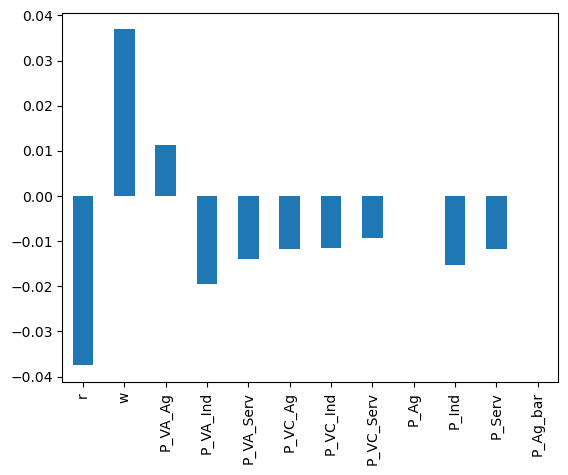

In [507]:
capital_supply_res.to_frame().pct_change(axis=1)["fitted"].loc[
    lambda x: x.index.str.startswith("P") | x.index.isin(["r", "w"])
].plot.bar()